<a href="https://colab.research.google.com/github/felipecacique/Pytorch-Tutorial-Youtube/blob/main/Modelo_Final_Salvo_Felipe_Novos_Modelos__2022_clean2_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>

## Create a NN model using PyTorch

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [216]:
# Create a model class that inherit nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -- >
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3, dropout_prob=0.5):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)

    return x

In [217]:
# Pick a manual seed foro randomization
torch.manual_seed(42)
# Create and instance if model
model = Model()

## Trading Strategy using Classification

The key steps involved in creating the strategy are:
1. Import data
2. Create indicators
3. Calculate returns
4. Train and test data
5. Create output signals
6. Create the Machine Learning Model
7. Predict the signals
8. Analyze the performance
9. Plot the results

### Import libraries

Next, we will import the necessary libraries for the strategy.

In [218]:
# Import the libraries
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import joblib
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import QuantileTransformer
import copy

## Import data

The 1-minute OHLCV data for the ICICI bank futures required for backtesting is saved in a CSV file, 'ICICI Minute Data.csv'. You can read this file and save it in a dataframe, Df.

To read a CSV file, you can use "pandas.read_csv()".

Syntax: pd.read_csv(filename)

filename: Name of the file in the string format

In [219]:
# Read the CSV file
Df = pd.read_csv("./win3.csv",delimiter=";",decimal=",")
Df.head()

,Time,O,Ret,FH4,FL4,FH0,FL0,FOPEN0
0,10/01/11 10:00,70100,0.000999,-0.025238,-0.002561,-0.002987,0.000000,0.000000
1,10/01/11 10:15,70280,0.001494,-0.022735,0.000000,-0.000995,0.002568,0.002568
2,10/01/11 10:30,70300,0.000996,-0.022457,0.000285,-0.000711,0.002853,0.002853
3,10/01/11 10:45,70310,0.001280,-0.022318,0.001282,-0.000569,0.002996,0.002996
4,10/01/11 11:00,70220,0.002136,-0.023569,0.000000,-0.003265,0.001712,0.001712


In [220]:
# from google.colab import drive
# drive.mount('/content/drive')

In [221]:
Df["Time"].dtype

dtype('O')

In [222]:
Df = Df.dropna()

In [223]:
#Convert the 'Time' column into pandas datetime format
Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)
Df.head()

<ipython-input-223-a53a9ba261cb>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Df['Time'] = pd.to_datetime(Df['Time'],dayfirst=True)


,Time,O,Ret,FH4,FL4,FH0,FL0,FOPEN0
0,2011-01-10 10:00:00,70100,0.000999,-0.025238,-0.002561,-0.002987,0.000000,0.000000
1,2011-01-10 10:15:00,70280,0.001494,-0.022735,0.000000,-0.000995,0.002568,0.002568
2,2011-01-10 10:30:00,70300,0.000996,-0.022457,0.000285,-0.000711,0.002853,0.002853
3,2011-01-10 10:45:00,70310,0.001280,-0.022318,0.001282,-0.000569,0.002996,0.002996
4,2011-01-10 11:00:00,70220,0.002136,-0.023569,0.000000,-0.003265,0.001712,0.001712


In [224]:
Df["Time"].dtype

dtype('<M8[ns]')

## Train and test data

We will be using 80% of the data to train and the rest 20% to test. To do this, you will create a split parameter which will divide the dataframe in an 80-20 ratio.

This can be changed as per your choice, but it is advisable to give at least 70% data as train data for good results. "split" is the integer index value for the row corresponding to test-train split.

In [225]:
pct_brincar = 1
#Para rodar da base inteira, comentar a linha abaixo e habilitar a linha de cima, com valor = 1
# Df = Df[:1000]
Df = Df[:int(pct_brincar*len(Df))]

In [226]:
# Create a variable split which is 80% of the length of the Dataframe
t = .8
split = int(t*len(Df))
split

61814

## Create output signals

Next, assign signal values corresponding to 'returns' that were calculated earlier. To do this, you will split the data into three equal parts, using the split on 'Ret' column.
1. Highest returns’ quantile is assigned Signal '1' or "Buy".
2. Middle quantile is assigned Signal '0' or 'Do nothing'.
3. Lowest quantile is assigned Signal '-1' or 'Sell'.

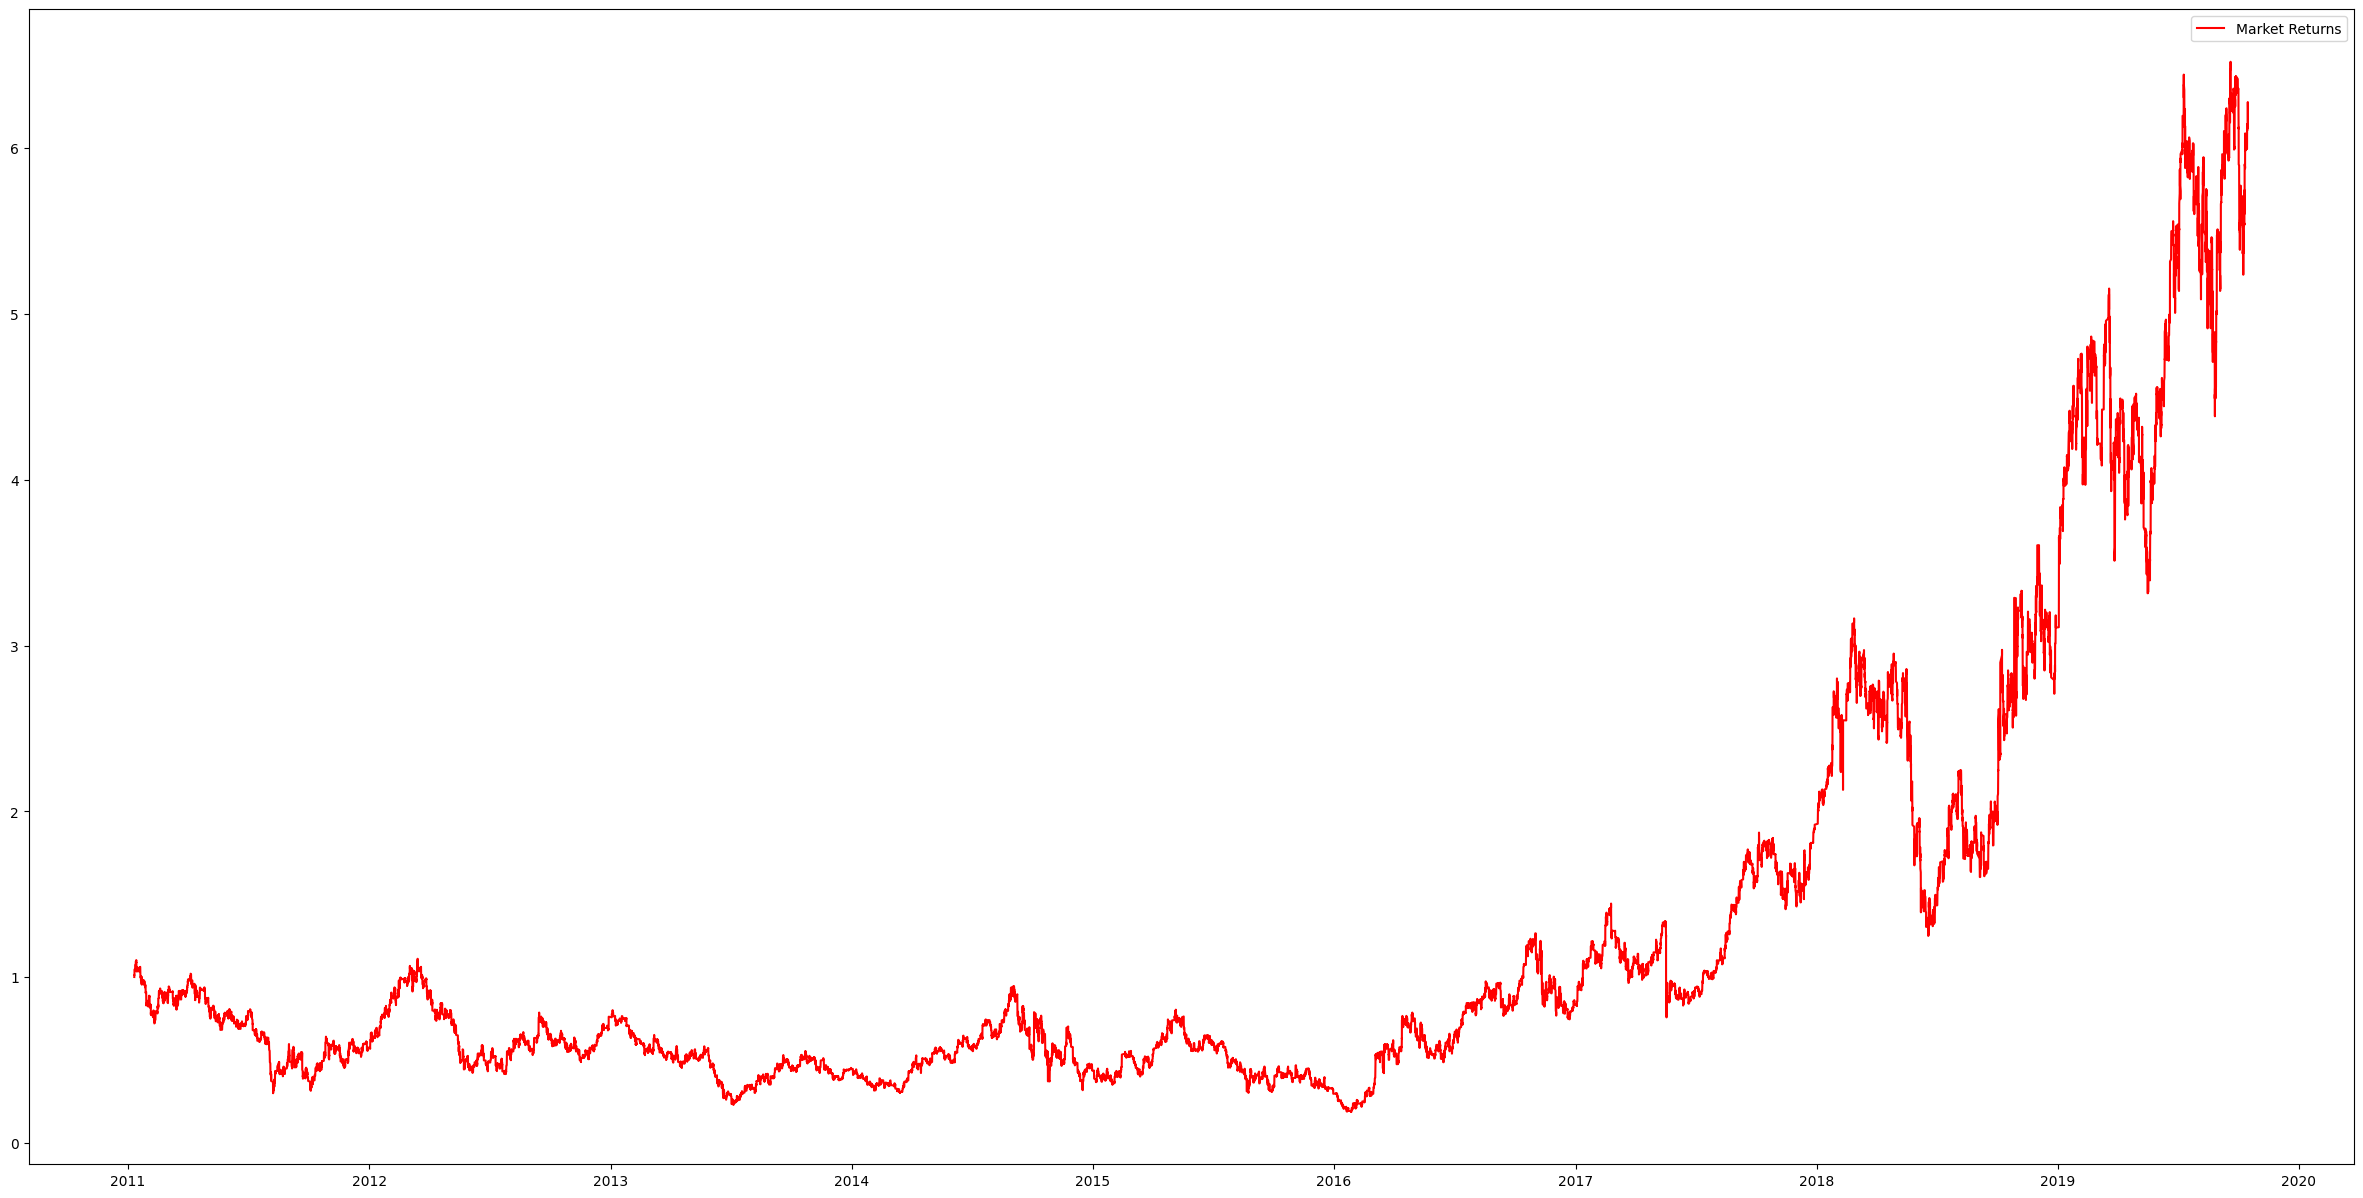

In [227]:
Retdf = Df.copy()
Retdf.set_index("Time", inplace=True)

# Plot the strategy returns
plt.figure(figsize=(30,15))
plt.plot(((Retdf['Ret']+1).cumprod()),color='r',label='Market Returns')
plt.legend()
plt.show()

In [228]:
# Create a column by name, 'Signal' and initialize with 0
Df['Signal']=0

# Assign a value of 1 to 'Signal' column for the quantile with highest returns
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.66),'Signal']=1

# Assign a value of -1 to 'Signal' column for the quantile with lowest returns
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.33),'Signal']=-1

In [229]:
# # # It is necessary for daytrade only. If you are using daily candles, please comment the lines below

# # # Assign a value of 0 to 'Signal' column after 17h
# Df.loc[(Df['Time'].dt.hour>16), 'Signal']=0

# # Assign a value of 0 to 'Ret' column after 17h
# Df.loc[(Df['Time'].dt.hour>16), 'Ret']=0

One last step and then we will be ready with our data!  
### Creating the features and values

Drop the columns 'Close', 'Signal', 'Time', 'High', 'Low', 'Volume', and 'Ret' since the algorithm will not be trained on these features. Next, we assign 'Signal' to 'y' which is the output variable that you will predict using test data.   

In [230]:
# Use df.drop() to drop the columns
X = Df.drop(['Ret',"Time","Signal"],axis=1)

# Create a variable which contains all the 'Signal' values
y = Df['Signal']

## Create the Machine Learning Model

### Create the new Machine Leaning Model

In this line of code we instantiate a new machine learning model.

In [231]:
# Create a new QDA
cls = QuadraticDiscriminantAnalysis()

# Create a new MLP classifier
# cls = MLPClassifier(random_state=7, hidden_layer_sizes=(15,15,15), alpha=0.0001, activation='relu', max_iter=1000)

### Train the data

We will first scale the data before you fit it to the classifier to train on. To do this, you need to first instantiate the Standard Scaler function.

In [232]:
# Instantiate the StandardScaler
ss1 = StandardScaler()

# Instantiate the QuantileTransformer
# ss1 = QuantileTransformer()

You will use the scaled training data to train the classifier algorithm.

In [233]:
# Pass the scaled train data to the SVC classifier
cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])

QuadraticDiscriminantAnalysis()

Epoch: 0 and loss: 1.1113836765289307
Epoch: 10 and loss: 1.0923619270324707
Epoch: 20 and loss: 1.0914690494537354
Epoch: 30 and loss: 1.0899888277053833
Epoch: 40 and loss: 1.089892864227295
Epoch: 50 and loss: 1.0894315242767334
Epoch: 60 and loss: 1.088823914527893
Epoch: 70 and loss: 1.087885856628418
Epoch: 80 and loss: 1.0878959894180298
Epoch: 90 and loss: 1.086369514465332
Epoch: 100 and loss: 1.0860062837600708
Epoch: 110 and loss: 1.0855634212493896
Epoch: 120 and loss: 1.0842459201812744
Epoch: 130 and loss: 1.0843247175216675
Epoch: 140 and loss: 1.0838531255722046
Epoch: 150 and loss: 1.0832219123840332
Epoch: 160 and loss: 1.0836565494537354
Epoch: 170 and loss: 1.0835336446762085
Epoch: 180 and loss: 1.083135724067688
Epoch: 190 and loss: 1.082776665687561


Text(0.5, 0, 'Epoch')

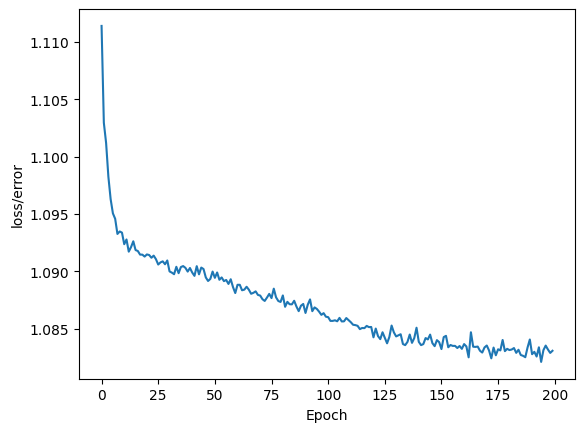

In [234]:
# Training the PyTorch NN model

num_features = X.shape[1]
model = Model(in_features=num_features, h1=25, h2=25, out_features=3)

# Convert X features to float tensors
X_train = torch.FloatTensor(ss1.fit_transform(X.iloc[:split].to_numpy()))
y_train = torch.LongTensor(y.iloc[:split].to_numpy()+1)


# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Chose Adam Optimizer, lr = learning rate (if error doesn't go sown after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Train our model!
# Epochs? (one run thry all the training data in our network)
epochs = 200
losses = []
for i in range(epochs):
  # Go forward and get prediction
  y_pred = model.forward(X_train) # Get predicted results

  # Measure the loss/errorm gonna be right at first
  loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses
  losses.append(loss.detach().numpy()) # transform the loss format to arr

  # print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of the forward propagation and feed it back
  # thru the network to fine tune the weight
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("Epoch")

Congratulations, your prediction model is ready!

In [235]:
joblib.dump(ss1,'ss1.joblib')
joblib.dump(cls,'cls.joblib')

['cls.joblib']

## Predict the signals

Now, you can use the test data to make predictions and save the value of output 'y' in a list called 'y_predict'. This list will have the predicted values of 'Signal' for the test data.  

In [236]:
ss1 = joblib.load('ss1.joblib')
cls = joblib.load('cls.joblib')

In [237]:
# Pass the test data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(X.iloc[split:]))
print(y_predict, len(y_predict))

[0 0 0 ... 0 0 0] 15454


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [238]:
# Predict the test using the PyTorch NN model

# Convert X features to float tensors
X_test = torch.FloatTensor(ss1.fit_transform(X.iloc[split:].to_numpy()))
y_test = torch.FloatTensor(y.iloc[split:].to_numpy())
y_predict = []

correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)
    y_predict.append(y_val.argmax().item() - 1)

    # Will tell us what type of flower class our network think it is
    # print(f'{i+1}: \t{str(y_val)} \t {y_val.argmax().item()} \t {y_test[i]}')

    # Correct or not
    if y_val.argmax().item() - 1 == y_test[i]:
      correct += 1

  print(f'We got {correct} correct of {len(X_test)}!')

y_predict = np.array(y_predict)
print(y_predict, len(y_predict))

We got 5807 correct of 15454!
[ 0  0  0 ...  0 -1  0] 15454


Now create a new column 'Pred_Signal' in 'Df' to save all the predictions for both train data and test data.

In [239]:
# Initiate a column by name, 'Pred_Signal' and assign 0 to it
Df['Pred_Signal'] = 0

### Save the predictions
1. To save predicted 'y' values of test data, we can simply assign 'y_predict' to 'Pred_Signal' using the split.
2. To save predicted 'y' values for train data, we make predictions for train data and save it similarly.

In [240]:
# Save the predicted values for the train data
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())

# Save the predicted values for the test data
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')] = y_predict

Df['Profit'] = Df['Pred_Signal']*Df['Ret']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [241]:
Df["Test_Set"] = 0
Df.loc[split:,"Test_Set"] = 1
Df.to_csv("output_pred.csv")

Since, the algorithm was trained on the train data, it’s accuracy of prediction is expected to be better on this train data compared to the test data. You can print these two seperately to check the accuracies. (TRY ON YOUR OWN!)

## Use the model for trading strategy

### Trading strategy
        
Our trading strategy is simply to buy/sell/do-nothing at that period for which the Signal is generated by the algorithm. The strategy assumes that you always get a fill at the "Open" prices.

You had already calculated and saved returns on 'Open' prices in 'Ret'. You will create a column named 'Ret1' to store the strategy's returns based on the Signal.

In [242]:
# Calculate strategy returns and store them in 'Ret1' column
Df['Ret1'] = Df['Ret']*Df['Pred_Signal']

## Analyze the performance

Please note that here you are using only the test data to compare the performance of the strategy. You can pass the entire 'Ret1' column and check the performance on both the test and train data if you wish to.

In [243]:
# Calculate the annualized Sharpe ratio
sharpe = np.sqrt(252) * Df['Ret1'][split:].mean() / Df['Ret1'][split:].std()

print('Sharpe', sharpe)

Sharpe 0.8806366871374054


In [244]:
# Calculate other metrics

def CalculateMetrics(returns,y_pred,dates,optimize=False,prediction_horizon=1,type_='percentual'):
    #Receive the dates, predictions and returns, apply a simple trading strategy (exit position after n candles, without tp and sl), and show the results and graph"""

    #--- get the returns if we follow the strategy (follow the prediction signals) - it is equivalent to buying or selling according to the signal, and keep the position for n candles. We can have multiple positions at the same time, without sl and tp
    strategy_returns=[y_pred[i]*returns[i] for i in range(0,len(y_pred))]

    #--- get the cumulative return of our strategy - increasing position - juros composto
    strategy_accumulated_prod = 1
    for i in range(1, len(strategy_returns)):
        strategy_accumulated_prod *= (strategy_returns[i]+1)
    strategy_accumulated_prod -= 1

    #--- get the cumulative return of our strategy
    strategy_accumulated = copy.copy(strategy_returns)
    for i in range(1, len(strategy_accumulated)):
        strategy_accumulated[i] = strategy_accumulated[i-1] + strategy_returns[i]

    #--- get the cumulative return of the asset - where we buy only, at every candle, and keeps the position opened for n candles
    asset_accumulated = copy.copy(returns)
    for i in range(1, len(asset_accumulated)):
        asset_accumulated[i] = asset_accumulated[i-1] + returns[i]


    #--- get the cumulative loss of our strategy - draw down
    strategy_drawdown = copy.copy(strategy_returns)
    for i in range(1, len(strategy_drawdown)):
        strategy_drawdown[i] = (strategy_drawdown[i-1] + strategy_returns[i] if strategy_drawdown[i-1] + strategy_returns[i] < 0 else 0)

    drawdown_max = np.min(np.array(strategy_drawdown))
    drawdown_mean = np.mean(np.array(strategy_drawdown))
    total_return = strategy_accumulated[-1]
    total_days = len(list(set([date.strftime("%Y-%m-%d") for date in dates])))
    total_months = total_days / 21
    monthly_return = (total_return/total_months if total_months>0 else 0)
    drawdown_max_by_monthly_return = (-drawdown_max/monthly_return if monthly_return != 0 else 0)
    drawdown_mean_by_monthly_return = (-drawdown_mean/monthly_return if monthly_return != 0 else 0)


    #--- calculating a few metrics

    if optimize:
        e = []
        for i,pred in enumerate(y_pred):
            if y_pred[max(0,i-prediction_horizon)] != pred: e.append(abs(pred))
        entries = np.sum(np.array(e))
    else:
        entries = np.sum(np.array([abs(pred) for pred in y_pred]))
        entries_buy = int(np.sum(np.array([abs(pred) for pred in y_pred if pred>0])))
        entries_sell = int(np.sum(np.array([abs(pred) for pred in y_pred if pred<0])))
    total_return = strategy_accumulated[-1]
    if entries>0:
        return_per_entry = total_return / entries
    else:
        return_per_entry = 0

    poss = sum([1 for return_ in strategy_returns if return_ > 0])
    negs = sum([1 for return_ in strategy_returns if return_ < 0])
    success = (poss+1) / (poss + negs+2)

    poss_ = sum([return_ for return_ in strategy_returns if return_ > 0])
    negs_ = sum([return_ for return_ in strategy_returns if return_ < 0])
    profitFactor = -((poss_+0.000001)/(negs_+0.000001))

    if type_ == 'percentual':
        print(
              "\n \tTotal return: ",round(total_return*100,4),"%",
              "\n \tEntries: ", entries,
              "\n \tReturn per entry: ", round(return_per_entry*100,4),"%",
              "\n \tSuccess: ", round(success*100,2),"%",
              "\n \tRatio: ", round(profitFactor,2),
              "\n \tTotal of days: ", total_days,
              "\n \tTotal of months: ", round(total_months,4),
              "\n \tMonthly return: ", round(monthly_return*100,4),"%",
              "\n \tMax drawdown: ", round(drawdown_max*100,4),"%",
              "\n \tMean drawdown: ", round(drawdown_mean*100,4),"%",
              "\n \tBuy signals", entries_buy,
              "\n \tSell signals", entries_sell,
              )
    else:
        print(
              "\n \tTotal return: ",round(total_return,4),
              "\n \tEntries: ", entries,
              "\n \tReturn per entry: ", round(return_per_entry,4),
              "\n \tSuccess: ", round(success*100,2),"%",
              "\n \tRatio: ", round(profitFactor,2),
              "\n \tTotal of days: ", total_days,
              "\n \tTotal of months: ", round(total_months,4),
              "\n \tMonthly return: ", round(monthly_return,4),
              "\n \tMax drawdown: ", round(drawdown_max,4),
              "\n \tMean drawdown: ", round(drawdown_mean,4),
              "\n \tBuy signals", entries_buy,
              "\n \tSell signals", entries_sell,
              )

# Strategy Metrics
returns = list(Df['Ret'][split:])
y_pred = list(Df['Pred_Signal'][split:])
dates = list(Df['Time'][split:])
print("\nStrategy results %: ")
CalculateMetrics(returns,y_pred,dates,type_='percentual')

returns_absolute = list((Df['Ret']*Df['O'])[split:])
print("\nStrategy results: ")
CalculateMetrics(returns_absolute,y_pred,dates,type_='points')



# BuyOnlyBaseline
returns = list(Df['Ret'][split:])
y_pred = [1]*len(returns)
dates = Df['Time'][split:]
print("\nBuy Only (Baseline) results %: ")
CalculateMetrics(returns,y_pred,dates)

returns_absolute = list((Df['Ret']*Df['O'])[split:])
print("\nBuy Only (Baseline) results: ")
CalculateMetrics(returns_absolute,y_pred,dates,type_='points')


Strategy results %: 

 	Total return:  322.1006 % 
 	Entries:  9528 
 	Return per entry:  0.0338 % 
 	Success:  53.27 % 
 	Ratio:  1.24 
 	Total of days:  428 
 	Total of months:  20.381 
 	Monthly return:  15.804 % 
 	Max drawdown:  -18.8579 % 
 	Mean drawdown:  -3.9059 % 
 	Buy signals 5388 
 	Sell signals 4140

Strategy results: 

 	Total return:  273801.2039 
 	Entries:  9528 
 	Return per entry:  28.7365 
 	Success:  53.27 % 
 	Ratio:  1.24 
 	Total of days:  428 
 	Total of months:  20.381 
 	Monthly return:  13434.1712 
 	Max drawdown:  -15808.7432 
 	Mean drawdown:  -3364.7621 
 	Buy signals 5388 
 	Sell signals 4140

Buy Only (Baseline) results %: 

 	Total return:  114.251 % 
 	Entries:  15454 
 	Return per entry:  0.0074 % 
 	Success:  50.82 % 
 	Ratio:  1.05 
 	Total of days:  428 
 	Total of months:  20.381 
 	Monthly return:  5.6058 % 
 	Max drawdown:  -90.1936 % 
 	Mean drawdown:  -21.1319 % 
 	Buy signals 15454 
 	Sell signals 0

Buy Only (Baseline) results: 

 	Total 

## Plot the results

Now you can plot the results to visualize the performance.


In [245]:
Df.set_index("Time", inplace=True)

### Traning period

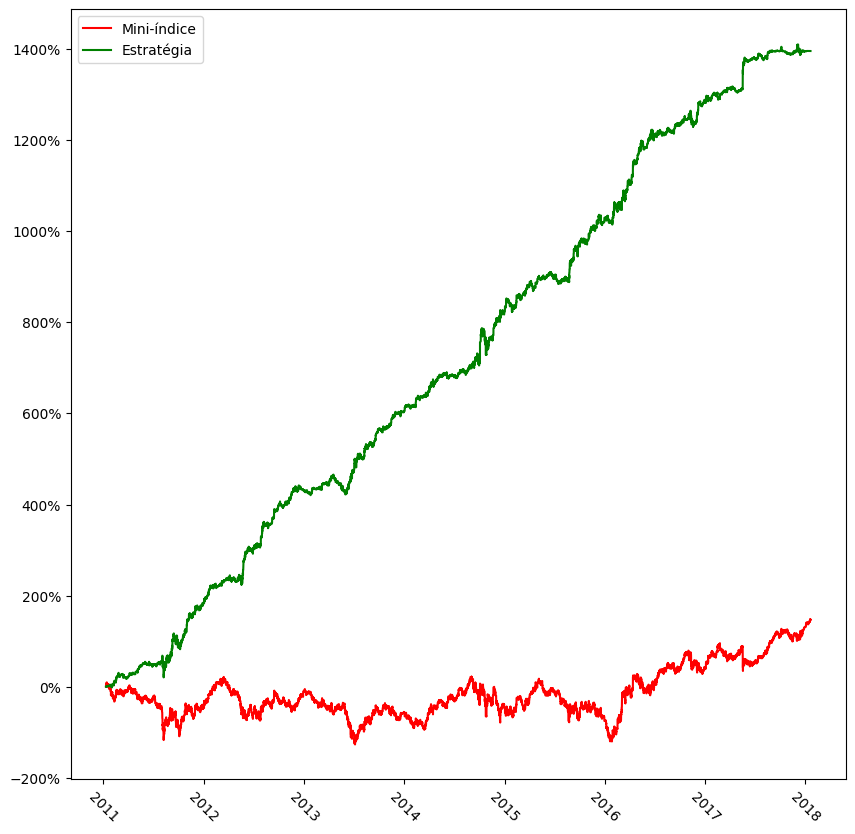

In [246]:
# Plot the strategy returns in the test period
plt.figure(figsize=(10,10))
# plt.plot(((Df['Ret'][:split]+1).cumprod()-1),color='r',label='Mini-índice')
# plt.plot(((Df['Ret1'][:split]+1).cumprod()-1),color='g',label='Estratégia')
plt.plot(((Df['Ret'][:split]).cumsum()),color='r',label='Mini-índice')
plt.plot(((Df['Ret1'][:split]).cumsum()),color='g',label='Estratégia')
plt.legend()
plt.xticks(rotation=-45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### Testing period

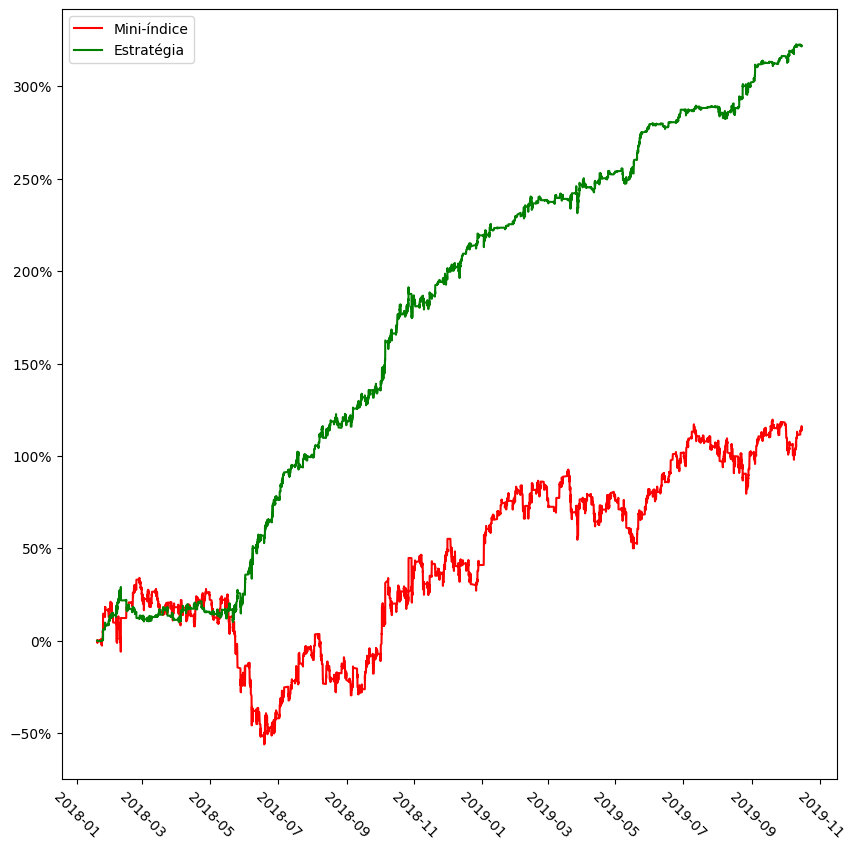

In [247]:
# Plot the strategy returns in the test period
plt.figure(figsize=(10,10))
# plt.plot(((Df['Ret'][split:]+1).cumprod()-1),color='r',label='Mini-índice')
# plt.plot(((Df['Ret1'][split:]+1).cumprod()-1),color='g',label='Estratégia')
plt.plot(((Df['Ret'][split:]).cumsum()),color='r',label='Mini-índice')
plt.plot(((Df['Ret1'][split:]).cumsum()),color='g',label='Estratégia')
plt.legend()
plt.xticks(rotation=-45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Now, it's your turn!

### Tweak the code

You can tweak the code in the following ways:
1. Use different data sets – backtest and try out the model on different data sets!
2. Features – create your own features using different indicators that could improve the prediction accuracy
3. Try Gird Search for best hyperparameters selection. Try different kernels and check for results.
4. Change the trading strategy as you wish!


### Prediction with a new data
Getting new data

In [248]:
# Pass the new data in the format of a dictionary, with the same keys and orders from the datased used for training
new_data = {'O':[70100], 'FH4':[-0.025238], 'FL4':[-0.002561], 'FH0':[-0.002987], 'FL0':[0.00000], 'FOPEN0':[0.00000]}

# Transform the dictionary into a dataframe
x = pd.DataFrame(new_data)
print(x)

       O       FH4       FL4       FH0  FL0  FOPEN0
0  70100 -0.025238 -0.002561 -0.002987  0.0     0.0


Doing the prediction of the new data using the previously trained model

In [249]:
# Pass the new data to the predict function and store the values into 'y_predict'
y_predict = cls.predict(ss1.transform(x))
print('Prediction: ', y_predict)

Prediction:  [1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
